In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# 1. LOAD DATASET DARI FILE CSV
# encoding='ISO-8859-1' sering dibutuhkan untuk file Excel/CSV ritel lama
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

print("--- Info Awal Dataset ---")
print(f"Jumlah baris awal: {len(df)}")

# 2. DATA CLEANING
# Hapus baris yang tidak ada CustomerID-nya
df = df.dropna(subset=['CustomerID'])

# Hapus transaksi 'refund' atau error (Quantity negatif)
df = df[df['Quantity'] > 0]

# Konversi CustomerID jadi integer (biar rapi, bukan 12345.0)
df['CustomerID'] = df['CustomerID'].astype(int)

# Konversi InvoiceDate ke format tanggal yang benar
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 3. FEATURE ENGINEERING (Membuat kolom baru)
# Kita butuh 'Monetary', jadi kalikan Quantity * UnitPrice
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

print("\n--- Data Setelah Dibersihkan ---")
print(f"Jumlah baris bersih: {len(df)}")
print(df[['CustomerID', 'InvoiceDate', 'Quantity', 'TotalAmount']].head())

--- Info Awal Dataset ---
Jumlah baris awal: 541909

--- Data Setelah Dibersihkan ---
Jumlah baris bersih: 397924
   CustomerID         InvoiceDate  Quantity  TotalAmount
0       17850 2010-12-01 08:26:00         6        15.30
1       17850 2010-12-01 08:26:00         6        20.34
2       17850 2010-12-01 08:26:00         8        22.00
3       17850 2010-12-01 08:26:00         6        20.34
4       17850 2010-12-01 08:26:00         6        20.34


In [ ]:
# Tentukan tanggal analisis (Set 1 hari setelah transaksi terakhir di data)
analysis_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

print(f"Tanggal Analisis: {analysis_date.date()}")

# Hitung R, F, M per Customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                  # Frequency (Hitung Invoice unik)
    'TotalAmount': 'sum'                                     # Monetary
})

# Rename kolom
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

print("\n--- Hasil RFM (5 Teratas) ---")
print(rfm.head())

Tanggal Analisis: 2011-12-10

--- Hasil RFM (5 Teratas) ---
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [4]:
import datetime as dt

# Tentukan tanggal patokan (1 hari setelah transaksi terakhir di data)
analysis_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Hitung R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalAmount': 'sum'                                     # Monetary
})

# Rename kolom agar mudah dibaca
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [5]:
# Memberikan label skor 1 sampai 4
r_labels = [4, 3, 2, 1] # Dibalik: yang harinya Dikit dapat skor 4
f_labels = [1, 2, 3, 4] # Normal: yang belanja Sering dapat skor 4
m_labels = [1, 2, 3, 4] # Normal: yang uangnya Banyak dapat skor 4

# Membuat kolom skor baru
# Kita pakai .rank(method='first') untuk Frequency karena banyak yang nilainya sama (misal beli 1x)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels).astype(str)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels).astype(str)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels).astype(str)

# Gabungkan menjadi satu kode RFM (Contoh: "444" adalah pelanggan sempurna)
rfm['RFM_Segment'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Hitung Total Skor (Angka) untuk keperluan pengelompokan nanti
rfm['Total_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

print(rfm.head())

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment  \
CustomerID                                                                     
12346           326          1  77183.60       1       1       4         114   
12347             2          7   4310.00       4       4       4         444   
12348            75          4   1797.24       2       3       4         234   
12349            19          1   1757.55       3       1       4         314   
12350           310          1    334.40       1       1       2         112   

            Total_Score  
CustomerID               
12346                 6  
12347                12  
12348                 9  
12349                 8  
12350                 4  


In [6]:
def segment_customer(df):
    if df['Total_Score'] >= 10:
        return 'Champions (Sultan)'
    elif df['Total_Score'] >= 8:
        return 'Loyal Customers'
    elif df['Total_Score'] >= 6:
        return 'Potential Loyalist'
    elif df['Total_Score'] >= 4:
        return 'At Risk / Need Attention'
    else:
        return 'Lost / Hibernating'

# Terapkan fungsi di atas ke setiap baris data
rfm['Customer_Label'] = rfm.apply(segment_customer, axis=1)

# Lihat hasilnya
print(rfm[['Recency', 'Frequency', 'Monetary', 'Customer_Label']].sample(5))

            Recency  Frequency  Monetary            Customer_Label
CustomerID                                                        
16431           213          3    642.81        Potential Loyalist
16054           145          1    783.90  At Risk / Need Attention
16349           291          1     53.50        Lost / Hibernating
15414            10          3    774.90        Champions (Sultan)
18165           177          1    302.46  At Risk / Need Attention


C:\Users\Ghifari Aprilia\AppData\Local\Temp\ipykernel_34204\2046666789.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='viridis')


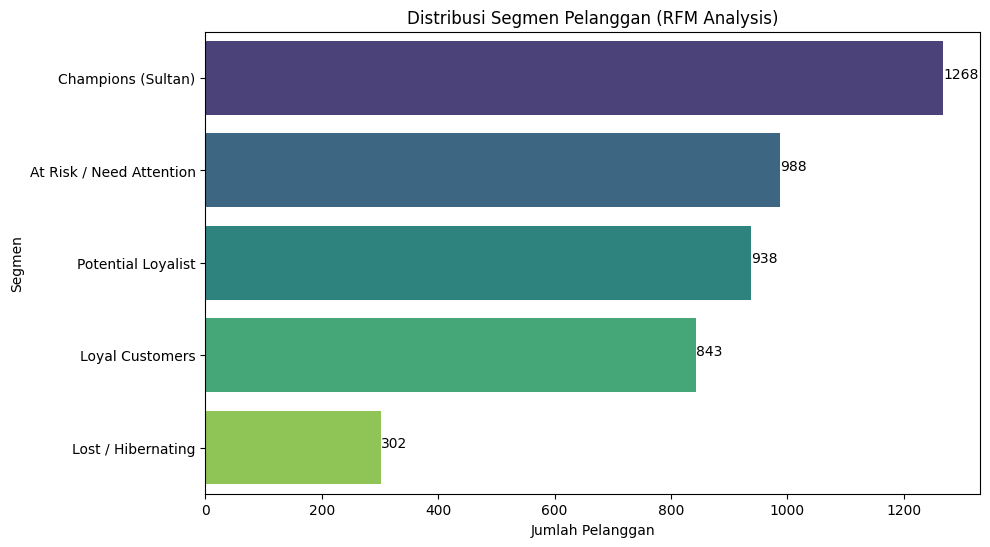

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hitung jumlah pelanggan di setiap segmen
segment_counts = rfm['Customer_Label'].value_counts().sort_values(ascending=False)

# 2. Buat Visualisasi Grafik Batang
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='viridis')

# Mempercantik grafik
plt.title('Distribusi Segmen Pelanggan (RFM Analysis)')
plt.xlabel('Jumlah Pelanggan')
plt.ylabel('Segmen')

# Menampilkan angka di ujung batang
for index, value in enumerate(segment_counts.values):
    plt.text(value, index, str(value))

plt.show()